In [1]:
import pylab
from pycbc.frame import read_frame
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries as TS
import bilby
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
import numpy as np
import healpy as hp
%matplotlib inline

merger = "GW170814"
gps = float(event_gps(merger))

In [2]:
sampling_rate = 4096
duration = 4. # length of data in seconds
start_time = gps-duration/2

interferometers = bilby.gw.detector.InterferometerList([])

for ifo_name in ['L1', 'H1', 'V1']:
    ifo = bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('data/'+merger+'_'+ifo_name+'_4KHZ.gwf', sampling_rate, duration, start_time=start_time, channel=ifo_name+':GWOSC-4KHZ_R1_STRAIN')
    ifo.maximum_frequency = 2048
    interferometers.append(ifo)

psd_alpha = 2 * interferometers[0].strain_data.roll_off / 4

L1_psd_data = TS.read('data/'+merger+'_L1_PSD.gwf', 'Strain')
L1_psd = L1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[0].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)

H1_psd_data = TS.read('data/'+merger+'_H1_PSD.gwf', 'Strain')
H1_psd = H1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)

V1_psd_data = TS.read('data/'+merger+'_V1_PSD.gwf', 'Strain')
V1_psd = V1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[2].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=V1_psd.frequencies.value, psd_array=V1_psd.value)

11:29 bilby INFO    : Reading data from frame file data/GW170814_L1_4KHZ.gwf
11:29 bilby INFO    : Successfully loaded L1:GWOSC-4KHZ_R1_STRAIN.
11:29 bilby INFO    : Reading data from frame file data/GW170814_H1_4KHZ.gwf
11:29 bilby INFO    : Successfully loaded H1:GWOSC-4KHZ_R1_STRAIN.
11:29 bilby INFO    : Reading data from frame file data/GW170814_V1_4KHZ.gwf
11:29 bilby INFO    : Successfully loaded V1:GWOSC-4KHZ_R1_STRAIN.


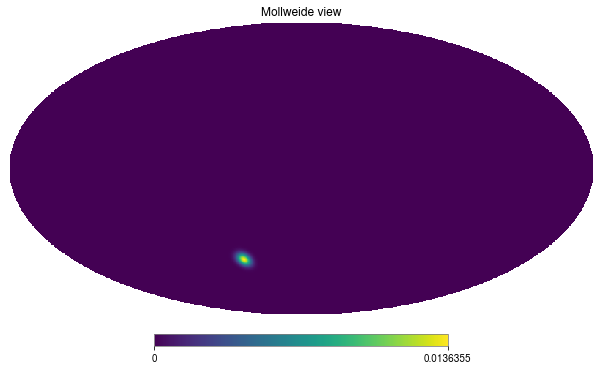

In [3]:
NSIDE = 1024
NPIX = hp.nside2npix(NSIDE)
hp_map = np.zeros(NPIX)

# bilby coordinates (ra, dec) -> healpix coordinates (pi/2 - dec, ra)
ra, dec = (.79, -.83)
theta, phi = (0.5*np.pi-dec, ra)

hp_map[hp.query_disc(nside=NSIDE, vec=hp.ang2vec(theta, phi), radius=0.02)] = 1
hp_map = hp.sphtfunc.smoothing(hp_map, sigma=0.04)
hp_map[hp_map<1e-5] = 0
hp_map = hp_map/np.linalg.norm(hp_map)
hp.mollview(hp_map)

In [4]:
hp.fitsfunc.write_map('data/hp_test_map.fits', hp_map, overwrite=True)

setting the output map dtype to [dtype('float64')]


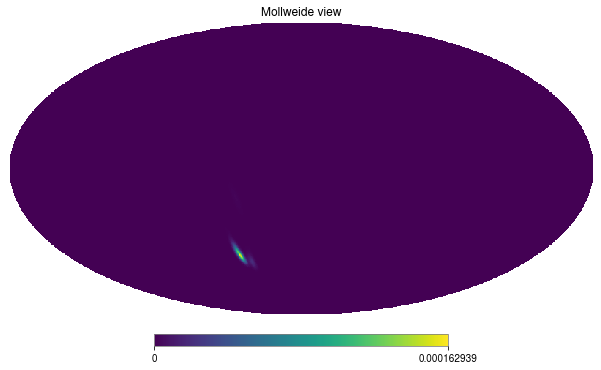

In [5]:
hp_gw = hp.fitsfunc.read_map('data/GW170814_skymap.fits.gz')
hp.mollview(hp_gw)

In [16]:
prior = bilby.core.prior.PriorDict()

prior["mass_ratio"] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.125, maximum=1)
prior["chirp_mass"] = bilby.core.prior.Uniform(name='chirp_mass', minimum=25, maximum=31)
prior["mass_1"] = bilby.core.prior.Constraint(name='mass_1', minimum=10, maximum=80)
prior["mass_2"] = bilby.core.prior.Constraint(name='mass_2', minimum=10, maximum=80)
prior["a_1"] = bilby.core.prior.Uniform(name='a_1', minimum=0, maximum=0.99)
prior["a_2"] = bilby.core.prior.Uniform(name='a_2', minimum=0, maximum=0.99)
prior["tilt_1"] = bilby.core.prior.Sine(name='tilt_1', boundary='reflective')
prior["tilt_2"] = bilby.core.prior.Sine(name='tilt_2', boundary='reflective')
prior["phi_12"] = bilby.core.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["phi_jl"] = bilby.core.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["theta_jn"] = bilby.core.prior.Sine(name='theta_jn', boundary='reflective')
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/hp_test_map.fits')
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=False)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short_hp',
    label='GW170814_hp_sim',
    nlive=100
)

12:02 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:02 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
12:02 bilby INFO    : Running for label 'GW170814_hp_sim', output will be saved to 'short_hp'
12:02 bilby INFO    : Using lal version 7.1.7
12:02 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:02 bilby INFO    : Using lalsimulation version 3.1.2
12:02 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications co

0it [00:00, ?it/s]

12:02 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb319432ee0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
12:02 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:02 bilby INFO    : Using dynesty version 1.0.1
12:02 bilby INFO    : Using the bil

12:49 bilby INFO    : Sampling time: 0:46:05.536178
12:49 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/4029 [00:00<?, ?it/s]

12:50 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/4029 [00:00<?, ?it/s]

12:50 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/4029 [00:00<?, ?it/s]

12:50 bilby INFO    : Summary of results:
nsamples: 4029
ln_noise_evidence: -26241.281
ln_evidence: -26096.449 +/-  0.292
ln_bayes_factor: 144.832 +/-  0.292



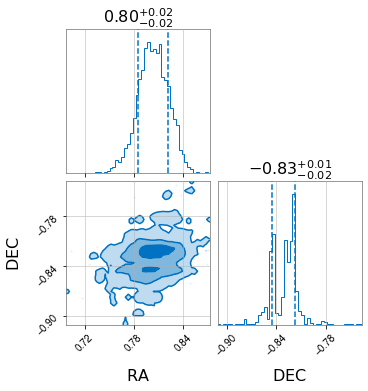

In [17]:
result_short.plot_corner(parameters=["ra", "dec"])

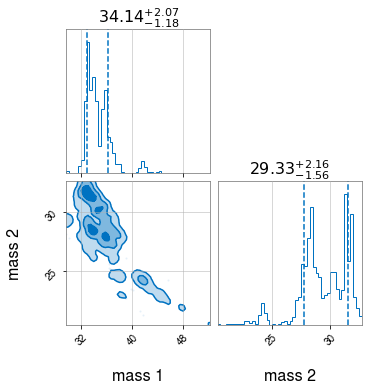

In [18]:
result_short.plot_corner(parameters=["mass_1", "mass_2"])

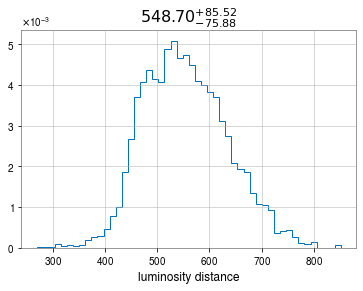

In [19]:
result_short.plot_corner(parameters=["luminosity_distance"])

Now using the published healpix map instead of the simulated one

In [14]:
prior = bilby.core.prior.PriorDict()

prior["mass_ratio"] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.125, maximum=1)
prior["chirp_mass"] = bilby.core.prior.Uniform(name='chirp_mass', minimum=25, maximum=31)
prior["mass_1"] = bilby.core.prior.Constraint(name='mass_1', minimum=10, maximum=80)
prior["mass_2"] = bilby.core.prior.Constraint(name='mass_2', minimum=10, maximum=80)
prior["a_1"] = bilby.core.prior.Uniform(name='a_1', minimum=0, maximum=0.99)
prior["a_2"] = bilby.core.prior.Uniform(name='a_2', minimum=0, maximum=0.99)
prior["tilt_1"] = bilby.core.prior.Sine(name='tilt_1', boundary='reflective')
prior["tilt_2"] = bilby.core.prior.Sine(name='tilt_2', boundary='reflective')
prior["phi_12"] = bilby.core.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["phi_jl"] = bilby.core.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["theta_jn"] = bilby.core.prior.Sine(name='theta_jn', boundary='reflective')
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/GW170814_skymap.fits.gz')
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short_hp',
    label='GW170814_hp_true',
    nlive=100,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
)

11:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:31 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
11:31 bilby INFO    : Running for label 'GW170814_hp_true', output will be saved to 'short_hp'
11:31 bilby INFO    : Using lal version 7.1.7
11:31 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
11:31 bilby INFO    : Using lalsimulation version 3.1.2
11:31 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications c

0it [00:00, ?it/s]

11:31 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb305fac2e0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
11:31 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:31 bilby INFO    : Using dynesty version 1.0.1
11:31 bilby INFO    : Using the bilb

  0%|          | 0/1574 [00:00<?, ?it/s]

11:58 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/1574 [00:00<?, ?it/s]

11:58 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/1574 [00:00<?, ?it/s]

11:59 bilby INFO    : Summary of results:
nsamples: 1574
ln_noise_evidence: -26241.281
ln_evidence: -26097.390 +/-  0.433
ln_bayes_factor: 143.891 +/-  0.433



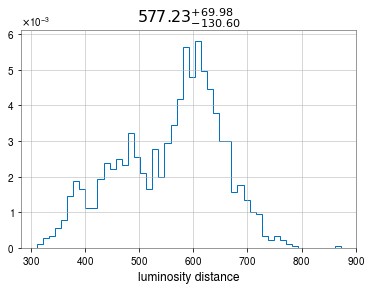

In [15]:
result_short.plot_corner(parameters=["luminosity_distance"])

In [28]:
prior = bilby.core.prior.PriorDict()

prior["mass_ratio"] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.125, maximum=1)
prior["chirp_mass"] = bilby.core.prior.Uniform(name='chirp_mass', minimum=25, maximum=31)
prior["a_1"] = bilby.core.prior.Uniform(name='a_1', minimum=0, maximum=0.99)
prior["a_2"] = bilby.core.prior.Uniform(name='a_2', minimum=0, maximum=0.99)
prior["tilt_1"] = bilby.core.prior.Sine(name='tilt_1', boundary='reflective')
prior["tilt_2"] = bilby.core.prior.Sine(name='tilt_2', boundary='reflective')
prior["phi_12"] = bilby.core.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["phi_jl"] = bilby.core.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["theta_jn"] = bilby.core.prior.Sine(name='theta_jn', boundary='reflective')
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/hp_test_map.fits')
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=50., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_rate,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers, waveform_generator)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short_hp',
    label='GW170814_hp_basic',
    nlive=100
)

14:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:49 bilby INFO    : Running for label 'GW170814_hp_basic', output will be saved to 'short_hp'
14:49 bilby INFO    : Using lal version 7.1.7
14:49 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:49 bilby INFO    : Using lalsimulation version 3.1.2
14:49 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:49 bilby INFO    : Search parameters:
14:49 bilby INFO    :   mass_ratio = Uniform(minimum=0.125,

0it [00:00, ?it/s]

14:49 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb2f4dd2fa0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
14:49 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:49 bilby INFO    : Using dynesty version 1.0.1
14:49 bilby INFO    : Using the bilb

15:07 bilby INFO    : Summary of results:
nsamples: 2452
ln_noise_evidence: -26241.281
ln_evidence: -26098.702 +/-  0.612
ln_bayes_factor: 142.579 +/-  0.612



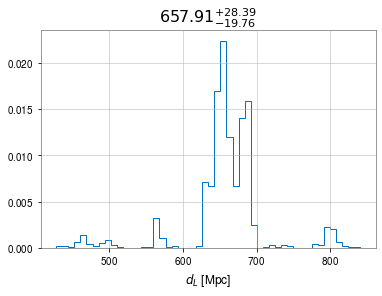

In [29]:
result_short.plot_corner(parameters=["luminosity_distance"])

Idea: Assuming that this H0 analysis will be done on BBH mergers that have already been parameterized, we will have the parameters to plug in as delta function priors. This should theoretically greatly reduce our calculation time. It would be better if we could adjust BAYESTAR for this use because it runs orders of magnitudes faster and directly works only with localization.

This cuts down the runtime from ~1-2 hours to ~20 mins, but delta function priors significantly changed the distance posterior. Will try to use the full published GW170814 posteriors as priors.

I think the ideal setup is a BAYESTAR-like MCMC that takes a 3d galaxy density prior and then spits out a similar posterior. The current HEALPix setup only has a single-mode gaussian distribution for the distance distribution at each pixel. The BAYESTAR paper suggests that all that is needed for localization is the times, amplitudes, and phases of the signals at each ifo.

BAYESTAR: signal --> localization 3d healpix (5 min) <br>
lalinference: signal --> all parameters + 3d healpix (100h) <br>
bilby: signal + healpix prior --> all parameters (2h) <br>

In [22]:
prior = bilby.core.prior.PriorDict()

prior["mass_ratio"] = 1.214
prior["chirp_mass"] = 24.1
prior["a_1"] = 0.4
prior["a_2"] = 0.4
prior["tilt_1"] = 0.22876
prior["tilt_2"] = 0.13858
prior["phi_12"] = 0.0
prior["phi_jl"] = 0.0
prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["theta_jn"] = 1.0
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/hp_test_map.fits')
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short_hp',
    label='GW170814_hp_inject',
    nlive=100,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
)

13:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:29 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:29 bilby INFO    : Running for label 'GW170814_hp_inject', output will be saved to 'short_hp'
13:29 bilby INFO    : Using lal version 7.1.7
13:29 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:29 bilby INFO    : Using lalsimulation version 3.1.2
13:29 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications

0it [00:00, ?it/s]

13:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb305d9da00>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
13:29 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:29 bilby INFO    : Using dynesty version 1.0.1
13:29 bilby INFO    : Using the bilb

  0%|          | 0/815 [00:00<?, ?it/s]

13:40 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/815 [00:00<?, ?it/s]

13:40 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/815 [00:00<?, ?it/s]

13:40 bilby INFO    : Summary of results:
nsamples: 815
ln_noise_evidence: -26241.281
ln_evidence: -26209.867 +/-  0.242
ln_bayes_factor: 31.413 +/-  0.242



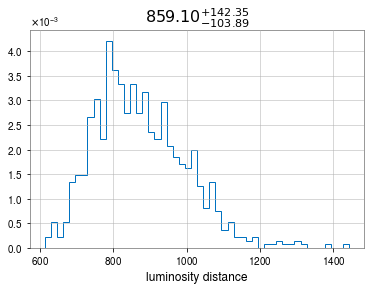

In [23]:
result_short.plot_corner(parameters=["luminosity_distance"])

Now the idea is to use the published posteriors as priors for bilby. I made a gaussian KDE prior that should plug into bilby, and I'll estimate the posteriors with KDEs and plug them in as priors. (THIS DOES NOT WORK)

This method loses higher order correlations, so maybe I need to do a multivariate KDE and somehow code that in? I'll need to check how bilby handles Joint priors if I think that's worthwhile.

It may be more useful to try to replicate what BAYESTAR does in bilby, just use the time/phase/power information from each ifo to estimate the localization instead of doing all 15 parameters. This would involve moving away from bilby's built-in BBH estimators and basically going off on my own. The likelihoods need to be tweaked in that case.

In [12]:
from scipy.special import ndtr
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
import h5py
import matplotlib.pyplot as plt

BBH = h5py.File('data/GW170814_GWTC-1.hdf5', 'r')

class KDEPrior(bilby.core.prior.base.Prior):

    def __init__(self, kde, name=None, latex_label=None, unit=None, boundary=None):
        super(KDEPrior, self).__init__(name=name,
                                       latex_label=latex_label,
                                       unit=unit,
                                       boundary=boundary,
                                       minimum=np.min(kde.dataset),
                                       maximum=np.max(kde.dataset)
                                      )
        self.kde = kde
    
    def cdf(self, val):
        try:
            cdf = np.array(tuple((kde.integrate_box_1d(self.minimum, item) for item in val)))
        except KeyError:
            cdf = kde.integrate_box_1d(self.minimum, val)
        return cdf

    def rescale(self, val):
        bound = np.linspace(self.minimum, self.maximum, 1000)
        f = interp1d(self.cdf(bound), bound, kind='linear', bounds_error=False)
        return f(val)

    def prob(self, val):
        return kde.pdf(val)

    def ln_prob(self, val):
        return kde.logpdf(val)

right_ascension = 0.81575316 with a 90% C.I = 0.7091771587066191 -> 0.856305764


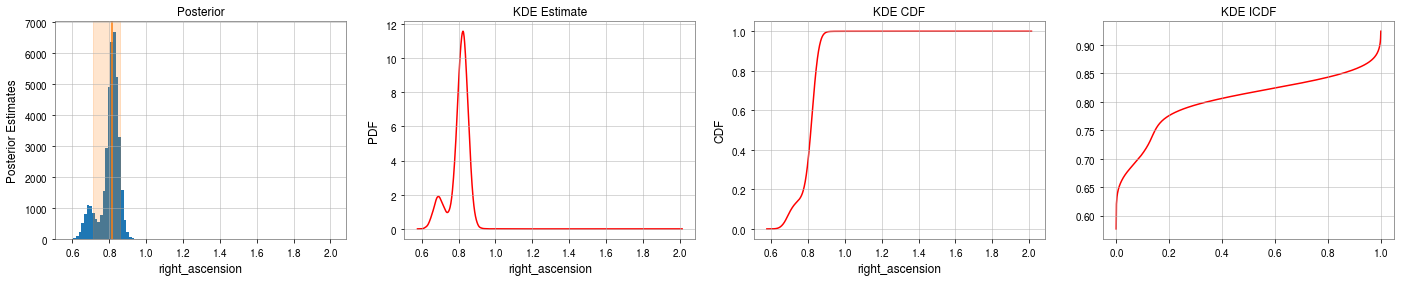

In [13]:
para = 'right_ascension'
post = BBH['Overall_posterior'][para]

lower_bound = np.quantile(post, 0.1)
upper_bound = np.quantile(post, 0.9)
median = np.quantile(post, 0.5)
print(para +" = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

kde = gaussian_kde(post)
kde_prior = KDEPrior(kde)
x = np.linspace(kde_prior.minimum, kde_prior.maximum, 1000)
y = np.linspace(0, 1, 1000)
kde_pdf = kde_prior.prob(x)
kde_cdf = kde_prior.cdf(x)
kde_icdf = kde_prior.rescale(y)

fig, ax = plt.subplots(1, 4, figsize=(24, 4))
ax[0].hist(post, bins=100)
ax[0].axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax[0].axvline(median, color='C1')
ax[0].set_title('Posterior')
ax[0].set_xlabel(para)
ax[0].set_ylabel('Posterior Estimates')
ax[1].plot(x, kde_pdf, c='r')
ax[1].set_title('KDE Estimate')
ax[1].set_xlabel(para)
ax[1].set_ylabel('PDF')
ax[2].plot(x, kde_cdf, c='r')
ax[2].set_title('KDE CDF')
ax[2].set_xlabel(para)
ax[2].set_ylabel('CDF')
ax[3].plot(y, kde_icdf, c='r')
ax[3].set_title('KDE ICDF')
plt.show()

In [ ]:
prior = bilby.core.prior.PriorDict()

prior["mass_1"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['m1_detector_frame_Msun']))
prior["mass_2"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['m2_detector_frame_Msun']))
prior["a_1"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['spin1']))
prior["a_2"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['spin2']))
prior["tilt_1"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['costilt1']))
prior["tilt_2"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['costilt2']))
prior["phi_12"] = bilby.core.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["phi_jl"] = bilby.core.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["theta_jn"] = KDEPrior(gaussian_kde(BBH['Overall_posterior']['costheta_jn']))
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/hp_test_map.fits')
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short_hp',
    label='GW170814_hp_kde',
    nlive=100,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
)